In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [16]:
from torch.utils.data import DataLoader

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
import torch

In [27]:
import matplotlib.pyplot as plt

In [7]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

In [8]:
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [12]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [13]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [14]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [15]:
train_data.targets.size()

torch.Size([60000])

In [17]:
loaders = {
    'train': DataLoader(train_data, 
                        batch_size=100, 
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),    
}

In [18]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x15acd3eb0e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x15acd32b110>}

In [19]:
loaders['train']

In [35]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return x

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for  batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders["train"].dataset)} ({100. * batch_idx/ len(loaders["train"]):.0f}%)] \t {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} {(100. * correct / len(loaders['test'].dataset)):.0f}% \n")

In [38]:
#CrossEntropyLoss computes softmax internally. It expects raw logits and not probabilities. 
#Do not use softmax when using CrossEntropyLoss. 
#If using softmax, use NLLLoss instead

In [37]:
for epoch in range(1,11):
    train(epoch)
    test()

Train Epoch: 1 [0 / 60000 (0%)] 	 2.295273
Train Epoch: 1 [2000 / 60000 (3%)] 	 2.164426
Train Epoch: 1 [4000 / 60000 (7%)] 	 1.746723
Train Epoch: 1 [6000 / 60000 (10%)] 	 1.272058
Train Epoch: 1 [8000 / 60000 (13%)] 	 1.168480
Train Epoch: 1 [10000 / 60000 (17%)] 	 0.733059
Train Epoch: 1 [12000 / 60000 (20%)] 	 0.666042
Train Epoch: 1 [14000 / 60000 (23%)] 	 0.814611
Train Epoch: 1 [16000 / 60000 (27%)] 	 0.648986
Train Epoch: 1 [18000 / 60000 (30%)] 	 0.569190
Train Epoch: 1 [20000 / 60000 (33%)] 	 0.494583
Train Epoch: 1 [22000 / 60000 (37%)] 	 0.439391
Train Epoch: 1 [24000 / 60000 (40%)] 	 0.418565
Train Epoch: 1 [26000 / 60000 (43%)] 	 0.386004
Train Epoch: 1 [28000 / 60000 (47%)] 	 0.518887
Train Epoch: 1 [30000 / 60000 (50%)] 	 0.614693
Train Epoch: 1 [32000 / 60000 (53%)] 	 0.531087
Train Epoch: 1 [34000 / 60000 (57%)] 	 0.293998
Train Epoch: 1 [36000 / 60000 (60%)] 	 0.362829
Train Epoch: 1 [38000 / 60000 (63%)] 	 0.645852
Train Epoch: 1 [40000 / 60000 (67%)] 	 0.277168
Tra

torch.Size([1, 28, 28])
Prediction: 4


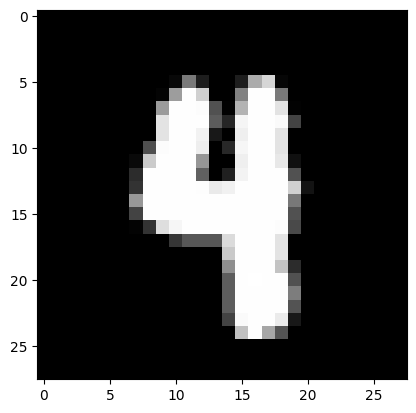

In [71]:
model.eval()

data, target = test_data[250]

print(data.shape)

data = data.unsqueeze(0).to(device)
# ex. [1,2] turns to [[1,2]] the datapoint is sent as a list of data points

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

In [41]:
print(data)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [44]:
data.shape

torch.Size([1, 1, 28, 28])

In [55]:
print(data.type)

<built-in method type of Tensor object at 0x0000015AD762D900>


In [49]:
from PIL import Image
import numpy as np

In [76]:
img = Image.open("test.png").convert("L")
img = img.resize((28,28))

img_arr = torch.tensor(np.array(img) / 255., dtype=torch.float32)
img_arr = img_arr.unsqueeze(0).unsqueeze(0).to(device)

In [77]:
print(img_arr)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3765, 0.8745, 1.0000,
           1.0000, 0.8745, 0.3765, 0.0000, 

In [78]:
img_arr.shape

torch.Size([1, 1, 28, 28])

Prediction: 5


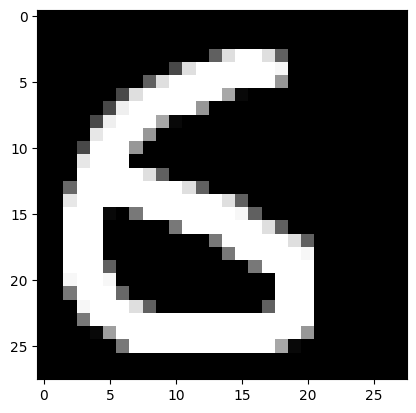

In [79]:
model.eval()

with torch.no_grad():
    output = model(img_arr)
    pred = output.argmax(dim=1, keepdim=True).item()

    print(f"Prediction: {pred}")

    img_arr = img_arr.squeeze(0).squeeze(0).cpu().numpy()
    plt.imshow(img_arr, cmap="gray")
    plt.show()